In [ ]:
%matplotlib inline

In [ ]:
import torch
import numpy as np

from agent.agent import Agent
from functions import *

stock_name = '^HSI_2018'
window_size = 10

agent = Agent(window_size, True)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
closes = []
buys = []
sells = []
capital = 100000

for t in range(l):
    action = agent.act(state)
    closes.append(data[t])

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        if capital > data[t]:
            agent.inventory.append(data[t])
            buys.append(data[t])
            sells.append(None)
            capital -= data[t]
        else:
            buys.append(None)
            sells.append(None)

    elif action == 2: # sell
        if len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            buys.append(None)
            sells.append(data[t])
            capital += data[t]
        else:
            buys.append(None)
            sells.append(None)
    elif action == 0:
        buys.append(None)
        sells.append(None)

    done = True if t == l - 1 else False
    agent.memory.push(state, action, next_state, reward)
    state = next_state

    if done:
        print("--------------------------------")
        print(stock_name + " Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x_data = range(l)

# From here the plotting starts

plt.figure(figsize=(10, 10))
plt.plot(x_data, closes)
plt.plot(x_data, buys, marker='o', markersize=8, markerfacecolor='r')
plt.plot(x_data, sells, marker='o', markersize=8, )
plt.title(stock_name)
plt.legend(['close', 'buy', 'sell'], loc='upper left')
plt.show()

In [1]:
%matplotlib inline

In [3]:
from rl_agent.Agent import Agent
from rl_agent.memory import Transition, ReplayMemory
from function import *
from param import *
from tqdm import tqdm

In [4]:
stock_name, window_size, episode_count =  "full_data", 10, 100


agent = Agent(window_size*5*5) # 10 sample and each sample is 5x5 
data = getStockDataVec()
l = len(data)/5
closes = []
buys = []
sells = []
capital = 100000


state = getState(data, window_size-1, window_size)
state

array([[3.955000e-01, 6.495850e+04, 5.500000e+01, 3.181810e+04,
        0.000000e+00, 1.871280e+03, 5.983403e+02, 6.620000e+02,
        3.413813e+02, 1.000000e+00, 3.377000e+02, 7.936300e+01,
        5.200000e+01, 2.967400e+01, 2.000000e+00, 2.925873e+04,
        5.296926e+01, 4.770000e+02, 2.693719e+01, 3.000000e+00,
        5.880000e+00, 9.487800e+02, 1.900000e+01, 1.302200e+02,
        4.000000e+00, 3.379000e+02, 1.203870e+02, 9.500000e+01,
        9.173400e+01, 2.000000e+00, 5.884000e+00, 1.275170e+03,
        3.200000e+01, 3.590500e+02, 4.000000e+00, 2.928583e+04,
        3.475878e+01, 4.710000e+02, 1.630834e+01, 3.000000e+00,
        3.964000e-01, 6.466610e+04, 1.140000e+02, 4.094000e+04,
        0.000000e+00, 1.877080e+03, 4.232665e+02, 4.770000e+02,
        2.625490e+02, 1.000000e+00, 5.879000e+00, 8.476400e+02,
        2.800000e+01, 1.819900e+02, 4.000000e+00, 3.369000e+02,
        2.630340e+02, 2.090000e+02, 8.522400e+01, 2.000000e+00,
        3.957000e-01, 2.617890e+04, 3.40

In [46]:
stock_name, window_size, episode_count =  "full_data", 10, 100


agent = Agent(window_size*5*5) # 10 sample and each sample is 5x5 
data = getStockDataVec()
l = len(data)/5
closes = []
buys = []
sells = []
capital = 100000


state = getState(data, window_size-1, window_size)

total_profit = 0
agent.inventory = []
# print(l)
# for t in range(window_size-1,l):

for i in range(1,round(l/10)):
	t= i*5

	action = agent.act(state)
 
	close_price = data[data['symbol']==BTCBUSD].loc[data.index[t]].close
 
	closes.append(close_price)
	# print(close_price)b

	# sit
	next_state = getState(data, t + 1, window_size)
	reward = 0

	if action == 1: # buy
		if capital > close_price:
			agent.inventory.append(data.loc[data.index[t]])
			buys.append(close_price)
			sells.append(None)
			capital -= close_price
		else:
			buys.append(None)
			sells.append(None)
		
	elif action == 2: # sell
		if len(agent.inventory) > 0:
      
			bought_price = agent.inventory.pop(0)
		
			# close_price = data[data['symbol']==BTCBUSD].loc[data.index[t]].close
			profit = close_price - bought_price[bought_price['symbol']==BTCBUSD].close.values.item()
			reward = max(profit, 0)
			total_profit += profit
			sells.append(close_price)
			buys.append(None)
			capital += close_price
		else:
			buys.append(None)
			sells.append(None)	
		# print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
		# print('total_profit: ',total_profit)
	elif action == 0:
		buys.append(None)
		sells.append(None)


	done = True if t%5 == 0 else False
	agent.memory.push(state, action, next_state, reward)
	state = next_state

	if done:
		print("--------------------------------")
		print("Total Profit: " + formatPrice(total_profit))
		print("--------------------------------")

--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $0.00
--------------------------------
--------------------------------
Total Profit: $21.56
--------------------------------
--------------------------------
Total Profit: $21.56
--------------------------------
--------------------------------
Total Profit: $21.56
--------------------------------
--------------------------------
Total Profit: $47.87
--------------------------------
--------------------------------
Total Profit: $34.41
--------------------------------
--------------------------------
Total Profit: $3

In [48]:
len(buys)

1986

In [43]:
len(closes)

1978

In [44]:
len(sells)

1978

In [36]:
x_data = range(len(closes))

In [37]:
x_data

range(0, 1978)

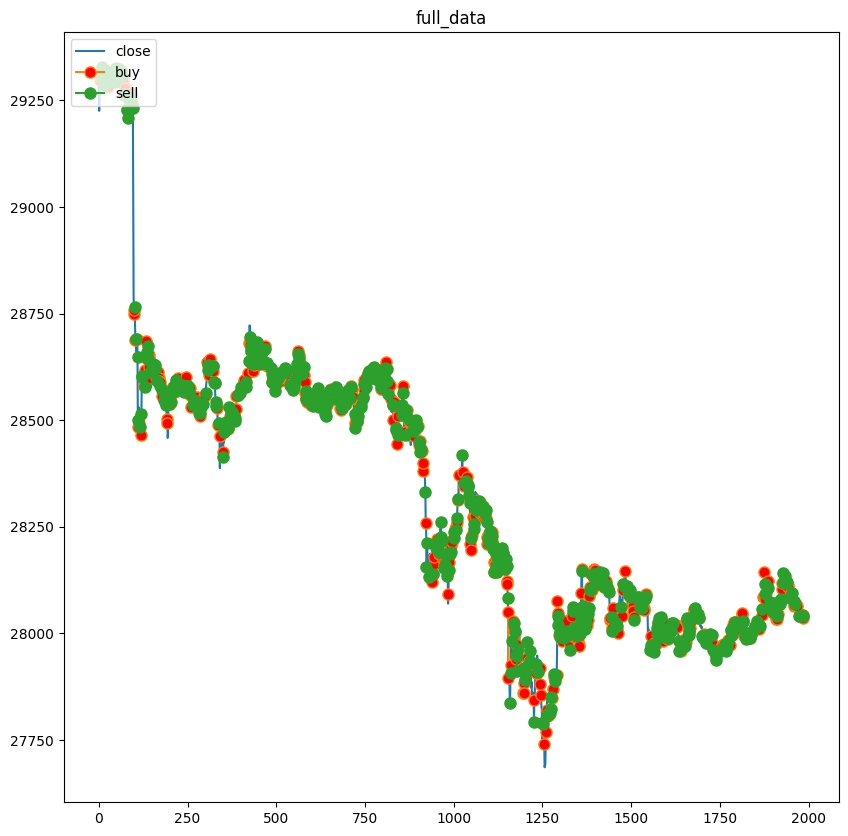

In [49]:
import matplotlib.pyplot as plt
import numpy as np


x_data = range(len(closes))


# From here the plotting starts

plt.figure(figsize=(10, 10))
plt.plot(x_data, closes)
plt.plot(x_data, buys, marker='o', markersize=8, markerfacecolor='r')
plt.plot(x_data, sells, marker='o', markersize=8, )
plt.title(stock_name)
plt.legend(['close', 'buy', 'sell'], loc='upper left')
plt.show()